# LSTM with Mean Interval Score Regression

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import pandas as pd
from torchts.nn.loss import mis_loss
from torchts.nn.model import TimeSeriesModel
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' 

# Set random seed for reproducibility

In [2]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

# Generate data

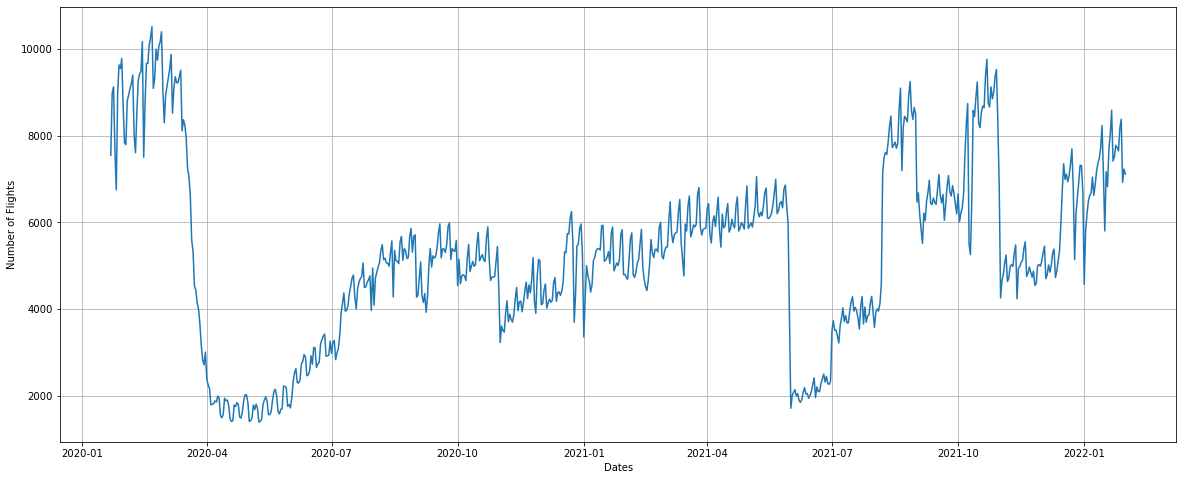

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('data.csv', sep=',', parse_dates=['Timestamp'], index_col='Timestamp',date_parser=dateparse)

plt.figure(figsize=(20,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Number of Flights')
plt.plot(data['Num_Flights']);
plt.show()

In [4]:
data

,Num_Flights,Num_Covid_Cases
Timestamp,,
2020-01-22,7545,655.0
2020-01-23,8979,98.0
2020-01-24,9124,286.0
2020-01-25,7654,492.0
2020-01-26,6751,684.0
...,...,...
2022-01-27,8174,3122335.0
2022-01-28,8376,3138982.0
2022-01-29,6924,2146044.0


In [5]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [6]:
xx = NormalizeData(np.linspace(0, 735, 736))
yy = NormalizeData(data.Num_Flights.values)

In [7]:
#x = torch.FloatTensor(data.Num_Covid_Cases.values.reshape(-1, 1))

# x = torch.from_numpy(np.linspace(0, 735, 736).reshape(-1, 1).astype(np.float32))
# y = torch.FloatTensor(data.Num_Flights.values.reshape(-1, 1))

x = torch.from_numpy(xx.reshape(-1, 1).astype(np.float32))
y = torch.FloatTensor(yy.reshape(-1, 1))

x.size(), y.size()

(torch.Size([736, 1]), torch.Size([736, 1]))

# Define model that predicts confidence intervals

In [8]:
class IntervalLSTM(TimeSeriesModel):
    def __init__(
        self, input_size, output_size, hidden_size, optimizer, interval=0.95, **kwargs
    ):
        super().__init__(
            optimizer,
            criterion=mis_loss,
            criterion_args={"interval": interval},
            **kwargs
        )
        self.lstm = nn.ModuleList(
            [nn.LSTMCell(input_size, hidden_size) for _ in range(output_size)]
        )
        self.linear = nn.ModuleList(
            [nn.Linear(hidden_size, 2) for _ in range(output_size)]
        )

    def forward(self, x, y=None, batches_seen=None):
        hidden, _ = zip(*[m(x) for m in self.lstm])
        out = [m(h) for m, h in zip(self.linear, hidden)]
        return torch.hstack(out)

In [9]:
input_size = 1
output_size = 1
hidden_size = 16
interval = 0.95
optimizer = optim.Adam
optimizer_args = {"lr": 0.005}
max_epochs = 100
batch_size = 10

model = IntervalLSTM(
    input_size,
    output_size,
    hidden_size,
    optimizer,
    interval=interval,
    optimizer_args=optimizer_args,
)

# Train model to predict confidence interval

In [10]:
# train model
model.fit(x, y, max_epochs=max_epochs, batch_size=batch_size)

# inference
y_preds = model.predict(x)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | lstm   | ModuleList | 1.2 K 
1 | linear | ModuleList | 34    
--------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

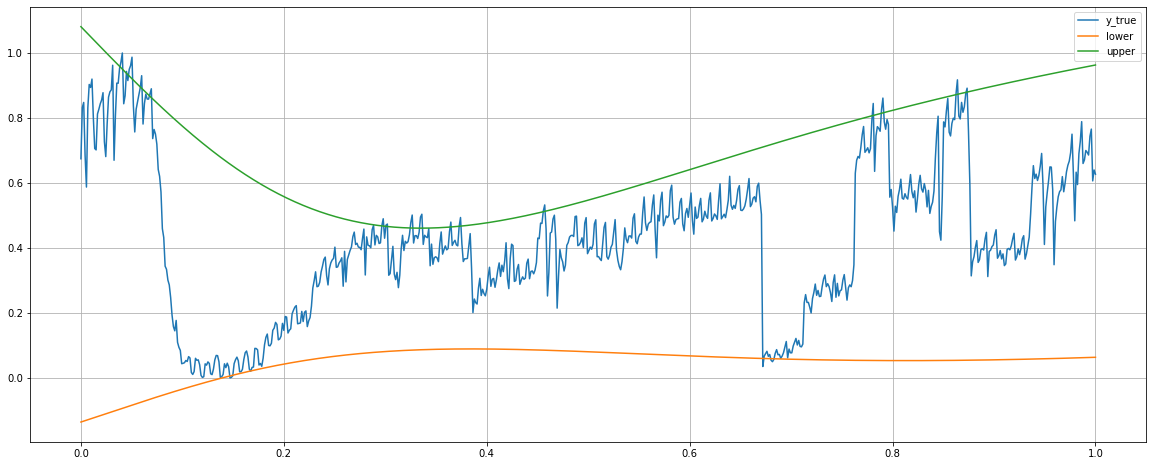

In [11]:
plt.figure(figsize=(20,8))
plt.grid(True)
plt.plot(x, y, label="y_true")
plt.plot(x, y_preds, label=["lower", "upper"])
plt.legend()
plt.show()

# Add second response variable

In [12]:
n = 736
x_max = 10
slope = 2
scale = 2

In [13]:
y_max = slope * x_max
y2 = 2 * y_max / (1 + np.exp(-x)) - y_max
y2 += np.random.normal(0, scale, n).reshape(-1, 1).astype(np.float32)
y = torch.hstack([y, y2])

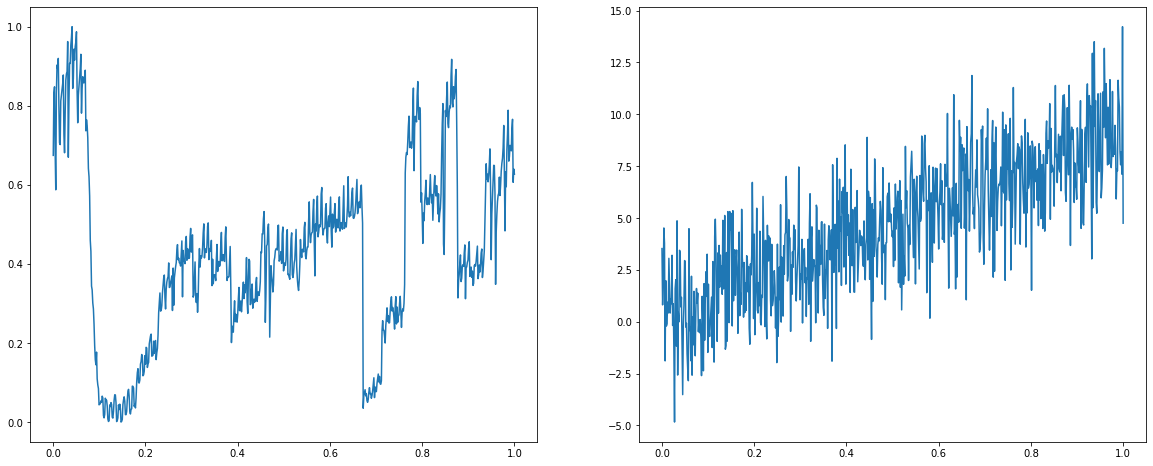

In [14]:
plt.figure(figsize=(20,8))
plt.grid(True)

plt.subplot(1, 2, 1)
plt.plot(x, y[:, 0])

plt.subplot(1, 2, 2)
plt.plot(x, y[:, 1])
plt.show()

# Train model to predict two confidence intervals

In [15]:
output_size = 2

model = IntervalLSTM(
    input_size,
    output_size,
    hidden_size,
    optimizer,
    interval=interval,
    optimizer_args=optimizer_args,
)

In [16]:
# train model
model.fit(x, y, max_epochs=max_epochs, batch_size=batch_size)

# inference
y_preds = model.predict(x)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | lstm   | ModuleList | 2.4 K 
1 | linear | ModuleList | 68    
--------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

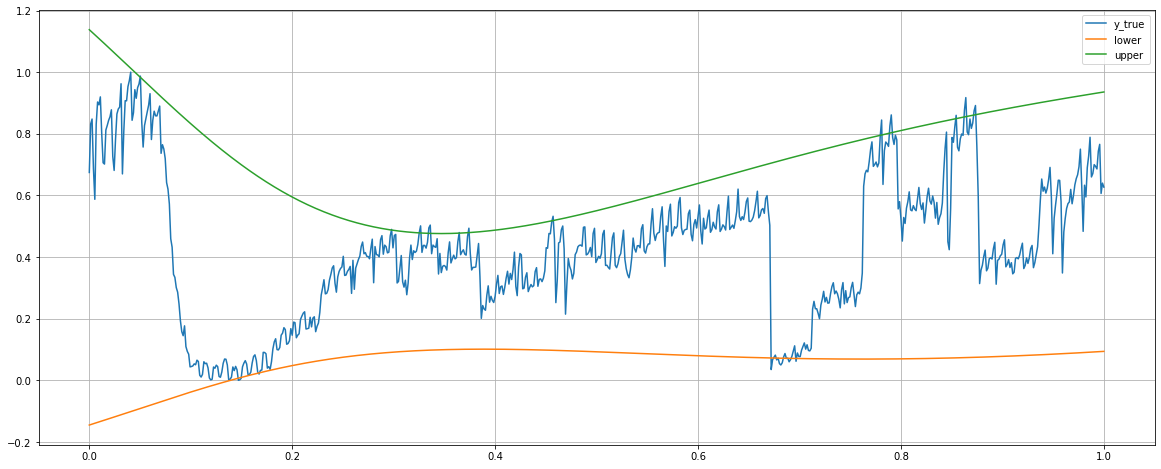

In [17]:
plt.figure(figsize=(20,8))
plt.grid(True)
plt.plot(x, y[:, 0], label="y_true")
plt.plot(x, y_preds[:, :2], label=["lower", "upper"])
plt.legend()
plt.show()

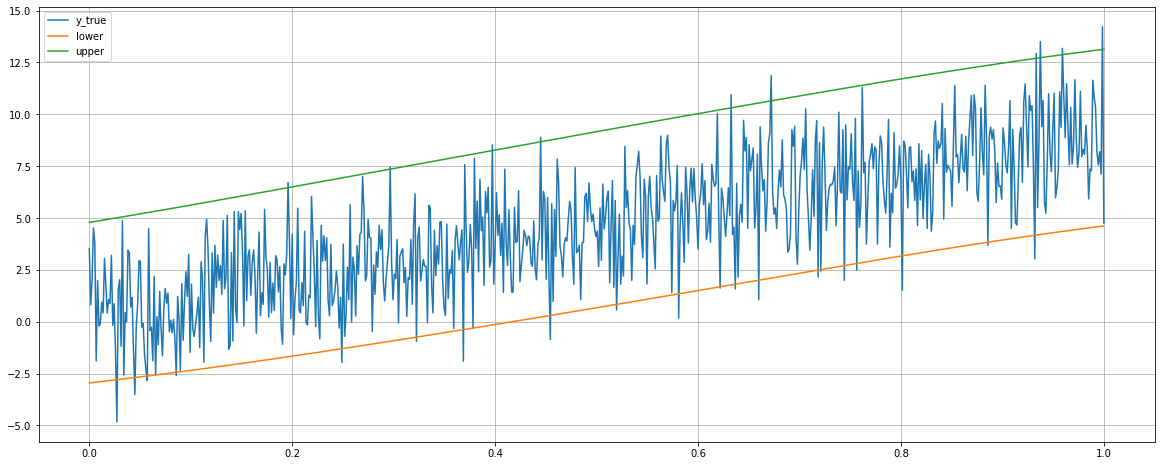

In [18]:
plt.figure(figsize=(20,8))
plt.grid(True)
plt.plot(x, y[:, 1], label="y_true")
plt.plot(x, y_preds[:, 2:], label=["lower", "upper"])
plt.legend()
plt.show()